In [1]:
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import pickle
import polars as pl
import seaborn as sns
from sklearn.metrics import auc, precision_recall_curve, precision_score, recall_score, f1_score
from statistics import mean

In [2]:
dataset_names = [
    'abt-buy', 'amazon-google', 'walmart-amazon',
    'wdc_xlarge_computers', 'wdc_xlarge_shoes', 'wdc_xlarge_watches'
]
CONST_N = 5

In [3]:
def get_results(key):
    results = {
        'f1': [],
        'precision': [],
        'recall': [],
        'threshold': [],
        'f1_0.5': [],
        'precision_0.5': [],
        'threshold_0.5': [],
        'recall_0.5': []
    }
    for train in range(1, 6):
        all_y_prob = []
        for fold in range(10):
            epoch = sorted(
                glob(f'entity-matching-transformer/experiments/{key.upper()}-{train}-{fold}*/test_*.pickle'),
                key=lambda x: int(x.split('_')[-1].split('.')[0]),
                reverse=True
            )[0].split('_')[-1].split('.')[0]
            with open(glob(f'entity-matching-transformer/experiments/{key.upper()}-{train}-{fold}*/validation_{epoch}.pickle')[0], 'rb') as f:
                temp = pickle.load(f)
            all_y_prob.append(pl.DataFrame().select(
                pl.Series('y_prob', temp['probabilities'][:,1]),
                pl.Series('label', temp['labels']).cast(bool),
                pl.lit(fold).alias('fold'),
                pl.lit('val').alias('set')
            ).with_row_count('N').with_columns(
                pl.col('N') % 5
            ))
            with open(glob(f'entity-matching-transformer/experiments/{key.upper()}-{train}-{fold}*/test_{epoch}.pickle')[0], 'rb') as f:
                temp = pickle.load(f)
            all_y_prob.append(pl.DataFrame().select(
                pl.Series('y_prob', temp['probabilities'][:,1]),
                pl.Series('label', temp['labels']).cast(bool),
                pl.lit(fold).alias('fold'),
                pl.lit('test').alias('set')
            ).with_row_count('N').with_columns(
                pl.col('N') % 5
            ))
        all_y_prob = pl.concat(all_y_prob)
        for k in results:
            results[k].append([])
        for test in range(1, 6):
            for k in results:
                results[k][-1].append([])
            for fold in range(10):
                # find best threshold
                subset = all_y_prob.filter(pl.col('label') | (pl.col('N') < train))
                y_val = subset.filter(pl.col('set') == 'val')['label'].to_list()
                y_prob = subset.filter(pl.col('set') == 'val')['y_prob'].to_numpy()
                precision, recall, threshold = precision_recall_curve(y_val, y_prob)
                with np.errstate(divide='ignore', invalid='ignore'):
                    f1_scores = np.nan_to_num(2 * recall * precision / (recall + precision))
                threshold = threshold[np.argmax(f1_scores)]
                results['threshold'][-1][-1].append(threshold)

                # get test set results
                subset = all_y_prob.filter(pl.col('label') | (pl.col('N') < test))
                y_test = subset.filter(pl.col('set') == 'test')['label'].to_list()
                y_prob = subset.filter(pl.col('set') == 'test')['y_prob'].to_numpy()
                y_pred = y_prob > threshold
                results['precision'][-1][-1].append(precision_score(y_test, y_pred, zero_division=0.0))
                results['recall'][-1][-1].append(recall_score(y_test, y_pred))
                results['f1'][-1][-1].append(f1_score(y_test, y_pred))

                y_pred = y_prob > 0.5
                results['precision_0.5'][-1][-1].append(precision_score(y_test, y_pred, zero_division=0.0))
                results['recall_0.5'][-1][-1].append(recall_score(y_test, y_pred))
                results['threshold_0.5'][-1][-1].append(0.5)
                results['f1_0.5'][-1][-1].append(f1_score(y_test, y_pred))

            for k in results:
                results[k][-1][-1] = mean(results[k][-1][-1])
    return results

all_results = {key: get_results(key) for key in set(dataset_names)}

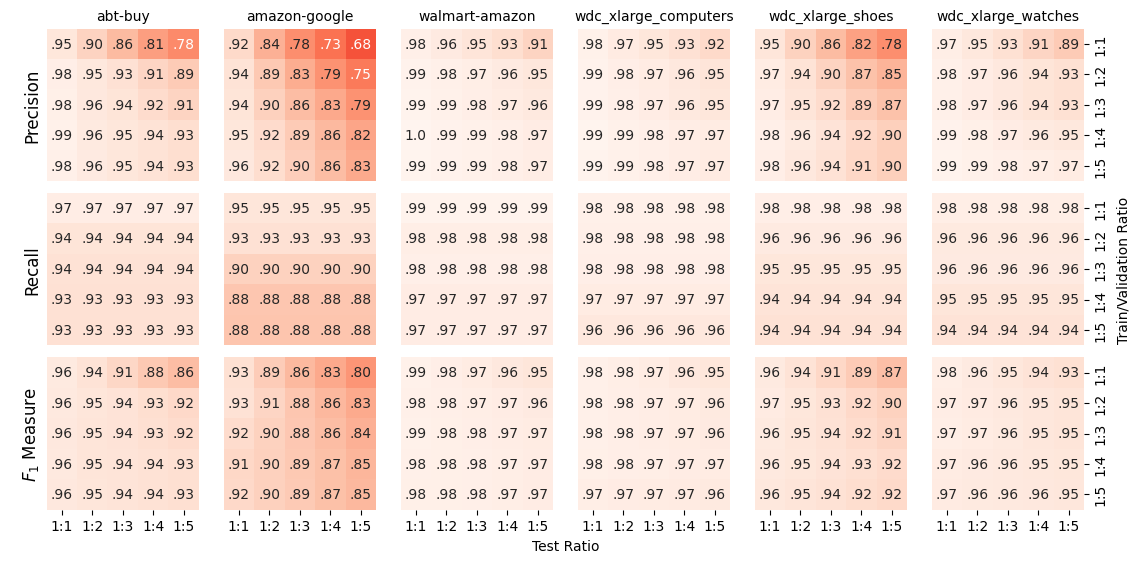

In [4]:
def title(key):
    if key == 'products_(Walmart-Amazon)':
        return 'walmart-amazon'
    return key

def plot(ax, k):
    results = all_results[key]
    sns.heatmap(
        np.pad(np.array(results[k]), (0, CONST_N - 5)),
        mask=~np.pad(np.full((5, 5), True), (0, CONST_N - 5)),
        annot=np.vectorize(lambda a: f'{a:.2}'[1:].ljust(3, '0').replace('.00', '1.0'))(np.pad(np.array(results[k]), (0, CONST_N - 5))),
        cmap='Reds_r',
        cbar=False,
        fmt='s',
        ax=ax,
        vmin=0.44,
        vmax=1,
        xticklabels=[f'1:{i}' for i in range(1, 6)],
        square=True
    )
    ax.yaxis.tick_right()
    ax.set_yticklabels([f'1:{i}' for i in range(1, 6)], va='center')
    ax.tick_params(bottom=False, right=False, labelbottom=False, labelright=False)

fig, axes = plt.subplots(3, 6, figsize=(12,6))
for i, key in enumerate(dataset_names):
    plot(axes[0][i], 'precision')
    axes[0][i].set_title(title(key), fontsize=10)
    plot(axes[1][i], 'recall')
    plot(axes[2][i], 'f1')

for i, label in enumerate(['Precision', 'Recall', '$F_1$ Measure']):
    axes[i][0].set_ylabel(label, fontsize=12)

for r in range(3):
    axes[r][5].tick_params(right=True, labelright=True)
for c in range(6):
    axes[2][c].tick_params(bottom=True, labelbottom=True)

# add a big axis, hide frame
ax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Test Ratio')
ax.yaxis.set_label_position("right")
ax.set_ylabel('Train/Validation Ratio', labelpad=20)
plt.tight_layout()
plt.show()